In [3]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') )
from jerks import jerks
import chaosmagpy as cp

# %%
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'):
    os.system('wget --no-verbose http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat')

# %%
# import the dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

# %%
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

# %%
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]
"""
# %%
"""


radius = 6371.2
theta = 80
phi = 30
jerk_number = 8 # in Python indexing

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)

SV_error = 10
discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
CP_NBINS = int(TIMES_MAX - TIMES_MIN) #one per year
    
time_intervals_edges = np.arange(-210,211,20) + jerk_times[jerk_number]
time_intervals_nbins = time_intervals_edges.shape[0]-1
SV = By_dot
delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
SV_MIN = -400
SV_MAX = 400

K_MIN = 0
K_MAX = 100
sigmas = np.array([10,5,10],dtype = float)
TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
# sigma_change_value = sigmas(1)
# sigma_move = sigmas(2)
# sigma_birth = sigmas(3)

THIN = 1000
NBINS = 100
credible = 0.0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2*2000000+burn_in
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
CP_hist_run = np.zeros( CP_NBINS, dtype=float )
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX, dtype=int)
delta_slope = np.zeros( time_intervals_nbins,dtype=float )
# print(sigmas, burn_in, NSAMPLE, NUM_DATA, delta_SV, SV_MIN, SV_MAX, TIMES_MIN, TIMES_MAX, time_intervals_nbins, THIN )
#print( SV_error, SV.max(),SV.min(), NUM_DATA)
print( radius, SV[0] )
(Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP_hist_run, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in,
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV,
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN,
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
CP_hist_run = CP_hist_run / ( (NSAMPLE-burn_in)/THIN )
print(CP_hist_run)
print(delta_slope)


Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]
6371.2 -24.90439484304261
[0.0235  0.3685  0.68175 0.9735  0.082   0.084   0.535   0.42275 0.05125
 0.155   0.998   0.26075 0.161   0.959   0.2185  0.997   0.139   0.8905
 0.051   0.968   0.03925]
[ 0.24189818  2.22418607  4.02231496  6.80622389  0.29649423  0.26216643
  0.98799834  1.03094472  0.10089275  0.52824567 67.76014567  1.28352231
  0.32374257 10.0395643   1.49159422  9.19141671  0.8128151   3.70327807
  0.1246398   5.48249174  0.91823174]


In [ ]:
6371.2 -24.904394843035334
[0.02   0.3965 0.6525 0.973  0.0745 0.081  0.544  0.419  0.0535 0.1515
 0.999  0.2885 0.153  0.9635 0.2215 0.995  0.1385 0.9065 0.0465 0.963
 0.038 ]
[ 0.37661318  2.79926776  3.76782171  6.68519396  0.26376192  0.3775237
  0.95568032  0.85160659  0.10292757  0.50914217 59.10075059  1.73021188
  0.48788166  9.44530004  1.25531484 10.78655198  2.9615904   3.45671539
  0.1244305   5.46977858  0.34695012]


In [ ]:
6371.0 -24.907694409823307
[0.022  0.361  0.69   0.968  0.086  0.09   0.5375 0.421  0.051  0.136
 0.9995 0.279  0.1365 0.962  0.218  0.994  0.149  0.8875 0.046  0.964
 0.0405]
[ 0.58705406  1.98371541  3.89316342  6.74313346  0.30646641  0.45461301
  1.02816104  1.17123766 26.20987126  0.4456229  62.69502187  9.29135336
  0.27374832  9.309506    1.4046503  20.50644924  0.62925594  3.44356379
  0.09621042  5.21061534  0.45555827]

In [ ]:
6370.8 -24.91099459828365
[0.02   0.377  0.6715 0.9725 0.068  0.073  0.5615 0.407  0.049  0.141
 0.9985 0.3    0.1345 0.9595 0.213  0.993  0.1615 0.8695 0.0535 0.961
 0.044 ]
[2.69482732e-01 2.17001192e+00 3.89395909e+00 7.03270302e+00
 2.73976349e-01 2.74243320e-01 9.76509715e-01 9.03469155e-01
 6.41550180e-02 8.26155448e-01 7.34066037e+01 2.80431060e+00
 2.73449070e-01 9.47729098e+00 1.43504881e+00 1.04191697e+01
 7.52165709e-01 4.44430945e+00 1.33179662e-01 5.16594256e+00
 1.96115862e+00]

302.31950671505945
302.25192565314387
302.18436184790653


(-100.0, 0.0)

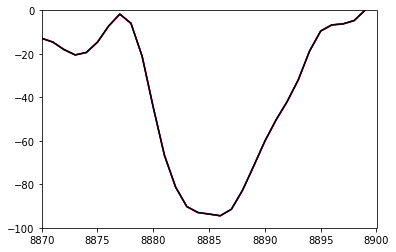

In [18]:
plt.figure()

radius = 6371.0 -  0.2
theta = 80
phi = 30
jerk_number = 8 # in Python indexing

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
plt.plot(time_yearly, By_dot,color='blue')
print(By_dot.max() - By_dot.min())

radius = 6371.0  
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
print(By_dot.max() - By_dot.min())

plt.plot(time_yearly, By_dot, color='red')

radius = 6371.0   + 0.2
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
print(By_dot.max() - By_dot.min())

plt.plot(time_yearly, By_dot, color='black')

plt.xlim([8870,8900])
plt.ylim([-100,0])


In [13]:
302.319 / 302.18436

1.0004455558189709